# Can we get NUTS to work with GPyTorch?

NUTS is No-U-Turn-Sampling, an MCMC sampler.  Can we get it to work with GPyTorch?  NUTS requires Pyro, the probabilistic programming language built on PyTorch, but it's not clear that the Pyro programming language and support GPyTorch likelihood objects...

In [1]:
import gpytorch

In [2]:
import celerite

In [3]:
import pyro

In [4]:
gpytorch.__version__, celerite.__version__, pyro.__version__

('0.3.6', '0.3.1', '0.4.1')

We'll need some other standard and astronomy-specific imports and configurations.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Redo

In [6]:
from celerite import terms

In [7]:
true_rho = 1.5
true_sigma = 1.2

In [8]:
true_log_sigma = np.log(true_sigma)
true_log_rho = np.log(true_rho)  # Has units of time, so 1/f

In [9]:
kernel_matern = terms.Matern32Term(log_sigma=true_log_sigma, log_rho=true_log_rho, eps=0.00001)

In [10]:
t_vec = np.linspace(0, 40, 2000)

In [11]:
gp = celerite.GP(kernel_matern, mean=0, fit_mean=True)
gp.compute(t_vec)
y_true = gp.sample()

In [12]:
y_true = 0.2*t_vec**2 + 0.3* t_vec - 7.0

In [13]:
noise = np.random.normal(0, 10.3, size=len(y_true))
y_obs = y_true + noise

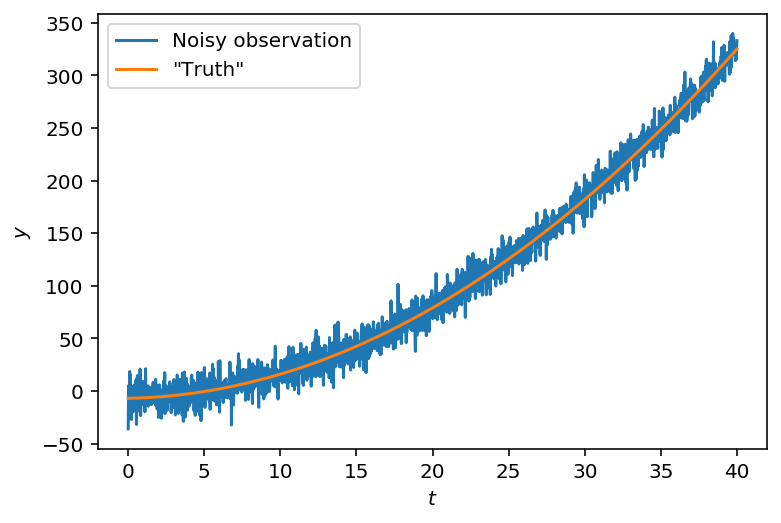

In [14]:
plt.plot(t_vec, y_obs, label='Noisy observation')
plt.plot(t_vec, y_true, label='"Truth"')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

Ok, we have a dataset to work with.

# Pyro and HMC

In [15]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS

The model is:

$y = a t^2 + b t + c$


In [16]:
def model(time_values, y_values):
    aa = pyro.sample("a", dist.Normal(0, 500))
    bb = pyro.sample("b", dist.Normal(0, 5000))
    cc = pyro.sample("c", dist.Normal(0., 5000.0))
    sigma = pyro.sample("sigma", dist.Uniform(10.0, 11.0))
    mean = aa * time_values**2 + bb * time_values + cc
    with pyro.plate("data", len(time_values)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y_values)

In [17]:
nuts_kernel = NUTS(model)

In [18]:
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=0)

In [19]:
t_ten = torch.from_numpy(t_vec)
y_ten = torch.from_numpy(y_obs)

train_x = t_ten.to(torch.float32)
train_y = y_ten.to(torch.float32)

In [20]:
mcmc.run(train_x, train_y)

sample: 100%|██████████| 500/500 [11:23<00:00,  1.37s/it, step size=4.88e-04, acc. prob=0.814]


In [21]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

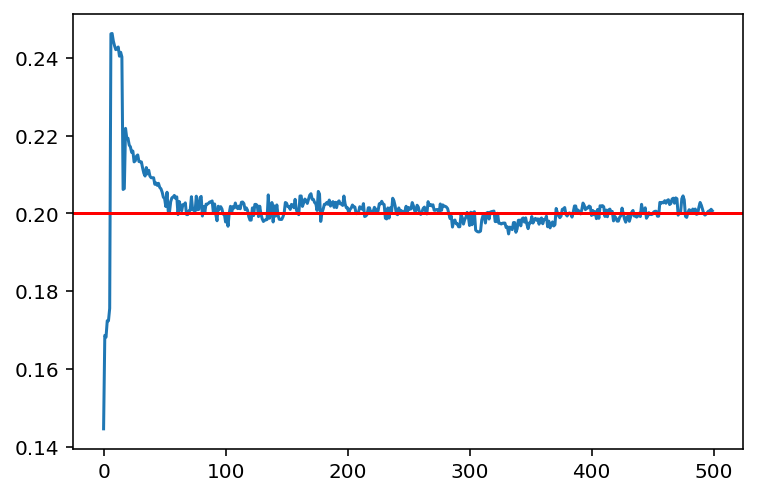

In [22]:
plt.plot(hmc_samples['a'])
plt.axhline(0.2, color='r')

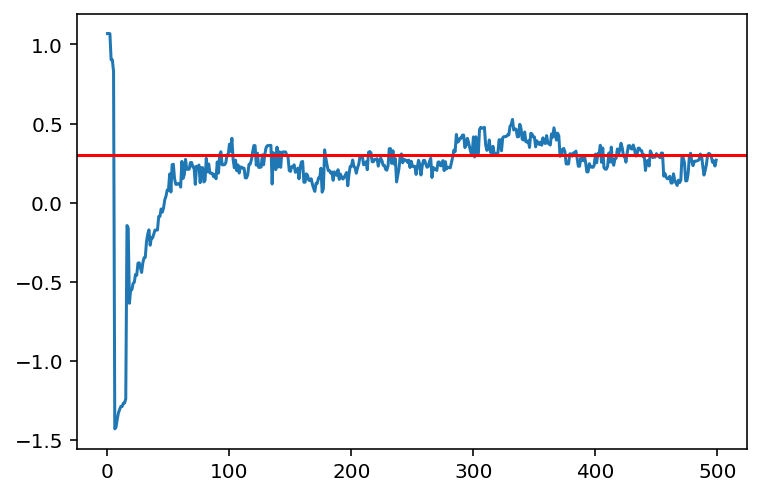

In [23]:
plt.plot(hmc_samples['b'])
plt.axhline(0.3, color='r')

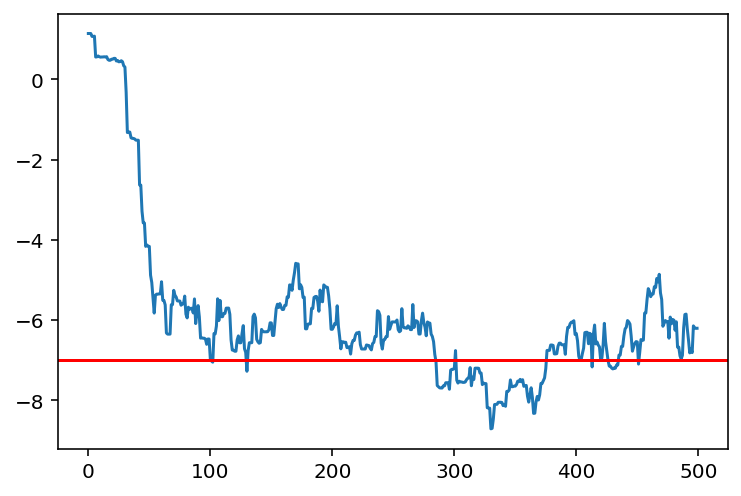

In [24]:
plt.plot(hmc_samples['c'])
plt.axhline(-7, color='r')

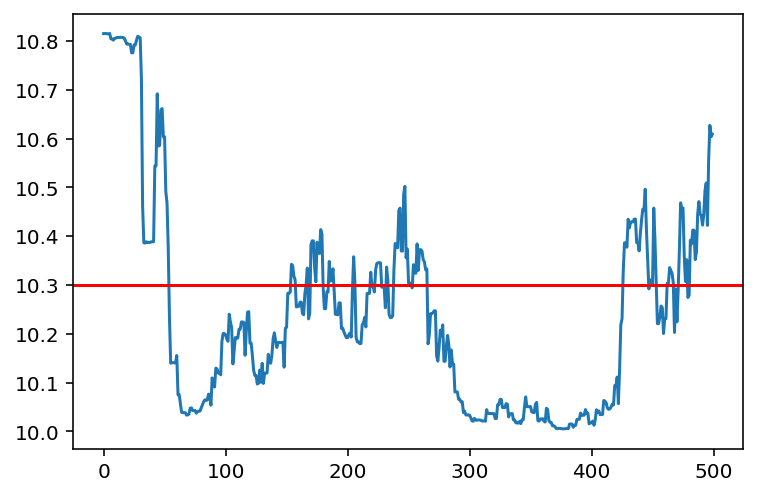

In [25]:
plt.plot(hmc_samples['sigma'])
plt.axhline(10.3, color='r')

Woohoo it works!  How to do it for GPs?

## How to apply HMC/NUTS to sample the GP parameters?

Currently variational inference is supported for GPyTorch through a Pyro integration.  I cannot find a way to do HMC/NUTS with GPyTorch though.  I wonder if it's possible?

In [13]:
import torch

In [14]:
t_ten = torch.from_numpy(t_vec)
y_ten = torch.from_numpy(y_obs)

train_x = t_ten.to(torch.float32)
train_y = y_ten.to(torch.float32)


```python
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
```

### How to do HMC/NUTS?